In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings; warnings.simplefilter('ignore')
import sys
import h5py
import pandas as pd
import seaborn as sns
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_ancillary
import jsm_stellarhalo
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models
import evolve as ev
import galhalo as gh
import profiles as profiles
import config as cfg

In [2]:
# analysis = pd.read_csv("../../../misc/for_Sebastian/analysis/mstar_mhalo/Read2017/mstar-mhalo-field.txt", delim_whitespace=True, header=None)

In [3]:
S0 = jsm_ancillary.load_sample("../../data/fiducial/S0_sample.h5")
S15 = jsm_ancillary.load_sample("../../data/fiducial/S15_sample.h5")
S30 = jsm_ancillary.load_sample("../../data/fiducial/S30_sample.h5")

In [4]:
plt.style.use('../../../SatGen/notebooks/paper1/paper.mplstyle')
double_textwidth = 7.0 #inches
single_textwidth = 3.5 #inches
levelz = [1-0.99, 1-0.95, 1-0.68]

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import scipy

# Dragonfly observations (Merritt et al. 2016)
# Corrected to be fair with Ghosts, Table 4 in Harmsen et al. 2017
galaxy_tag_dragonfly = np.array(["NGC1042", "NGC 1084", "NGC 2903", "NGC3351", "NGC3368", "NGC4220", "NGC4258", "M101"])
mstar_dragonfly = np.array([1.53e10, 4.32e10, 4.94e10, 5.84e10, 8.91e10, 6.11e10, 7.61e10, 5.89e10])
mstar_onesig_dragonfly = np.array([0.48e10, 1.41e10, 1.57e10, 1.95e10, 2.87e10, 1.96e10, 2.42e10, 1.87e10])
fraction_stellar_halo_dragonfly = np.array([0.0001, 0.15, 0.031, 0.068, 0.099, 0.027, 0.057, 0.012])
fraction_onesig_dragonfly = np.array([0.00003, 0.07, 0.021, 0.025, 0.0292, 0.022, 0.0159, 0.006])
fraction_upper_limits_dragonfly = np.array([True, False, False, True, True, False, True, True], dtype=bool)


# Ghosts observations (Harmsen+2017)
galaxy_tag_ghosts = np.array(["NGC253", "NGC891", "NGC3031", "NGC4565", "NGC4945", "NGC 7814"])
mstar_ghosts = np.array([5.5e10, 5.3e10, 5.6e10, 8.0e10, 3.8e10, 4.5e10])
mstar_onesig_ghosts = np.array([1.4e10, 1.3e10, 1.4e10, 2.0e10, 0.95e10, 1.1e10])
mstar_stellar_halo_ghosts = np.array([4.53e9, 2.69e9, 1.14e9, 2.24e9, 3.47e9, 6.41e9])
mstar_stellar_halo_plusonesig_ghosts = np.array([0.53e9, 0.23e9, 0.1e9, 0.1e9, 0.19e9, 1.34e9])
mstar_stellar_halo_minusonesig_ghosts = np.array([0.31e9, 0.16e9, 0.07e9, 0.1e9, 0.22e9, 0.81e9])
fraction_stellar_halo_ghosts = mstar_stellar_halo_ghosts / mstar_ghosts
fraction_worse_case = (mstar_stellar_halo_ghosts - mstar_stellar_halo_minusonesig_ghosts) / \
                      (mstar_ghosts + mstar_onesig_ghosts)
fraction_best_case = (mstar_stellar_halo_ghosts + mstar_stellar_halo_plusonesig_ghosts) / \
                      (mstar_ghosts - mstar_onesig_ghosts)
fraction_plusonesig_ghosts = fraction_best_case - fraction_stellar_halo_ghosts
fraction_minusonesig_ghosts = fraction_stellar_halo_ghosts - fraction_worse_case


# Milky Way and M31 (Read from Merritt+2016, Fig 5)
# Update following Deason+Belokurov+Sanders2019 for the MW
# Smercina+2020 for M81 and M82, stellar mass at bottom of page 18
# MW stellar halo mass Deason+Belokurov+Sanders2019, 1.4e9 +-0.4e9
# M81 stellar halo mass Smercina+2020, no error bars reported
galaxy_tag_mw = np.array(["MW", "M31", "M81"])
mstar_mw = np.array([7.5e10, 1e11, 2.8e10])
fraction_stellar_halo_mw = np.array([0.0186, 0.025, 0.041])
fraction_plusonesig_mw = np.array([5.4e-3, 0., 0.])
fraction_minusonesig_mw = np.array([5.3e-3, 0., 0.])

# """ Add comparison against TNG """
data = np.load("../../../collaborations/for_martin/data/pop_shalos_TNG300.npy")
stellar_masses = data[0, :]
stellar_halo_fractions = data[1, :] / stellar_masses

bins = np.logspace(9.5, 11.5, 40)
bin_centers = (bins[1:] + bins[:-1]) / 2
medians, _, _ = scipy.stats.binned_statistic(stellar_masses, stellar_halo_fractions, bins=bins, statistic='median')
plusonesig, _, _ = scipy.stats.binned_statistic(stellar_masses, stellar_halo_fractions,
                                                bins=bins, statistic=lambda input: np.percentile(input, 84))
plustwosig, _, _ = scipy.stats.binned_statistic(stellar_masses, stellar_halo_fractions,
                                                bins=bins, statistic=lambda input: np.percentile(input, 97.6))
minusonesig, _, _ = scipy.stats.binned_statistic(stellar_masses, stellar_halo_fractions,
                                                bins=bins, statistic=lambda input: np.percentile(input, 16))
minustwosig, _, _ = scipy.stats.binned_statistic(stellar_masses, stellar_halo_fractions,
                                                bins=bins, statistic=lambda input: np.percentile(input, 2.4))

In [6]:
# fig, ax1 = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)

# ax1.scatter(S30.target_stellarmass, S30.Mstar_ICL/S30.target_stellarmass, marker=".", s=2, c="grey")

# # Plot Dragonfly
# ax1.errorbar(mstar_dragonfly, fraction_stellar_halo_dragonfly, xerr=mstar_onesig_dragonfly,
#              yerr=fraction_onesig_dragonfly, uplims=fraction_upper_limits_dragonfly,
#              linewidth=0, markersize=5, marker='o', elinewidth=2, capsize=2,
#              label="Dragonfly", color='C0', ecolor='C0')

# # Plot GHOSTS
# ax1.errorbar(mstar_ghosts, fraction_stellar_halo_ghosts, xerr=mstar_onesig_ghosts,
#              yerr=[fraction_minusonesig_ghosts, fraction_plusonesig_ghosts],
#              linewidth=0, markersize=5, marker='o', elinewidth=2, capsize=2,
#              label="GHOSTS", color='C3', ecolor='C3')

# # # Plot MW
# ax1.errorbar(mstar_mw[0], fraction_stellar_halo_mw[0],
#              yerr=np.array([fraction_minusonesig_mw[0], fraction_plusonesig_mw[0]]).reshape((2, 1)),
#              linewidth=0, markersize=15, marker='*', elinewidth=2, capsize=3,
#              color='k', ecolor='k')

# # ax1.plot(mstar_mw[0], fraction_stellar_halo_mw[0], linewidth=0, markersize=5, marker="s", color="k")
# ax1.plot(mstar_mw[1], fraction_stellar_halo_mw[1], linewidth=0, markersize=5, marker="s", color="k")
# ax1.plot(mstar_mw[2], fraction_stellar_halo_mw[2], linewidth=0, markersize=5, marker="s", color="k", label="Local Volume")

# ax1.set_xscale('log')
# ax1.set_yscale('log')

# ax1.set_xlabel("log M$_{\\rm cen}$ [M$_{\odot}$]")
# ax1.set_ylabel("log (M$_{\\rm ASH}$ / M$_{\\rm cen}$)")
# ax1.set_ylim(0.003, 3)
# ax1.set_xlim(2e8)

# ax1.legend(loc=2, framealpha=1)



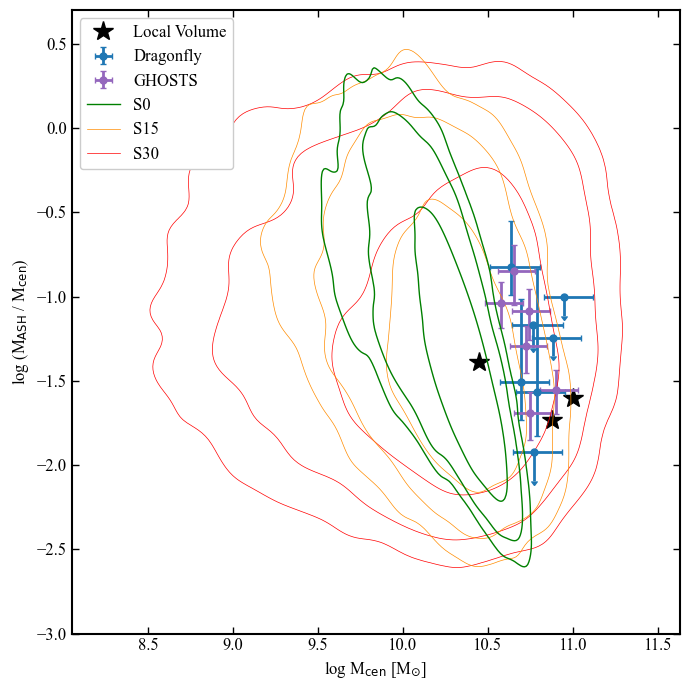

In [7]:
import seaborn as sns
import numpy as np

fig, ax1 = plt.subplots(figsize=(double_textwidth, double_textwidth))

# --- Convert MW to log-space ---
x_mw = np.log10(mstar_mw)
y_mw = np.log10(fraction_stellar_halo_mw)

ax1.plot(x_mw[0], y_mw[0], linewidth=0, markersize=15, marker="*", color="k")
ax1.plot(x_mw[1], y_mw[1], linewidth=0, markersize=15, marker="*", color="k")
ax1.plot(x_mw[2], y_mw[2], linewidth=0, markersize=15, marker="*", color="k", label="Local Volume")

# --- Convert Dragonfly data to log-space ---
x_dragonfly = np.log10(mstar_dragonfly)
y_dragonfly = np.log10(fraction_stellar_halo_dragonfly)
xerr_dragonfly = [np.log10(mstar_dragonfly + mstar_onesig_dragonfly) - x_dragonfly,
                  x_dragonfly - np.log10(mstar_dragonfly - mstar_onesig_dragonfly)]
yerr_dragonfly = [np.log10(fraction_stellar_halo_dragonfly + fraction_onesig_dragonfly) - y_dragonfly,
                  y_dragonfly - np.log10(fraction_stellar_halo_dragonfly - fraction_onesig_dragonfly)]

ax1.errorbar(x_dragonfly, y_dragonfly, xerr=xerr_dragonfly, yerr=yerr_dragonfly,
             uplims=fraction_upper_limits_dragonfly, linewidth=0, markersize=5,
             marker='o', elinewidth=2, capsize=2, label="Dragonfly", color='C0', ecolor='C0')

# --- Convert GHOSTS data to log-space ---
x_ghosts = np.log10(mstar_ghosts)
y_ghosts = np.log10(fraction_stellar_halo_ghosts)
xerr_ghosts = [np.log10(mstar_ghosts + mstar_onesig_ghosts) - x_ghosts,
               x_ghosts - np.log10(mstar_ghosts - mstar_onesig_ghosts)]
yerr_ghosts = [np.log10(fraction_stellar_halo_ghosts + fraction_plusonesig_ghosts) - y_ghosts,
               y_ghosts - np.log10(fraction_stellar_halo_ghosts - fraction_minusonesig_ghosts)]

ax1.errorbar(x_ghosts, y_ghosts, xerr=xerr_ghosts, yerr=yerr_ghosts,
             linewidth=0, markersize=5, marker='o', elinewidth=2, capsize=2,
             label="GHOSTS", color='C4', ecolor='C4')

sns.kdeplot(
    x=np.log10(S30.target_stellarmass),
    y=np.log10(S30.Mstar_ICL/S30.target_stellarmass),
    fill=False,        # No filled contour, just lines
    levels=levelz,          # Number of contour levels
    color="red",
    linewidths=0.5,
    ax=ax1)

sns.kdeplot(
    x=np.log10(S15.target_stellarmass),
    y=np.log10(S15.Mstar_ICL/S15.target_stellarmass),
    fill=False,        # No filled contour, just lines
    levels=levelz,          # Number of contour levels
    color="darkorange",
    linewidths=0.5,
    ax=ax1)


sns.kdeplot(
    x=np.log10(S0.target_stellarmass),
    y=np.log10(S0.Mstar_ICL/S0.target_stellarmass),
    fill=False,        # No filled contour, just lines
    levels=levelz,          # Number of contour levels
    color="green",
    linewidths=1,
    ax=ax1)

ax1.plot([], [], color="green", linestyle="-", lw=1, label="S0")
ax1.plot([], [], color="darkorange", linestyle="-", lw=0.5, label="S15")
ax1.plot([], [], color="red", linestyle="-", lw=0.5, label="S30")

ax1.set_xlabel("log M$_{\\rm cen}$ [M$_{\odot}$]")
ax1.set_ylabel("log (M$_{\\rm ASH}$ / M$_{\\rm cen}$)")

ax1.legend(loc=2, framealpha=1)
ax1.set_ylim(-3,0.7)
ax1.set_xlim(8.05)

# Get current legend handles and labels
handles, labels = ax1.get_legend_handles_labels()

# Reorder them manually: put S0, S15, S30 last
order = [i for i, lab in enumerate(labels) if lab not in ["S0", "S15", "S30"]] + \
        [labels.index("S0"), labels.index("S15"), labels.index("S30")]

ax1.legend([handles[i] for i in order],
           [labels[i] for i in order],
           loc=2, framealpha=1)

plt.tight_layout()
plt.savefig("../../figures/for_Martin.pdf", bbox_inches="tight")

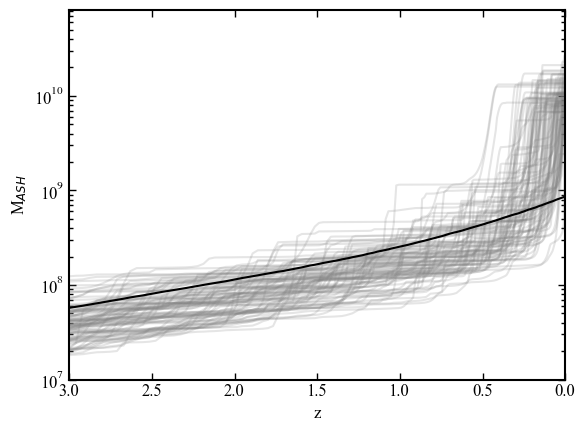

In [16]:
overmassive = np.where(np.log10(S0.Mstar_ICL/S0.target_stellarmass) > 0)[0]
test = S0.iloc[overmassive]
100*(overmassive.shape[0]/10000)
hmm = jsm_ancillary.make_matrix(S0, "MAH_ICL")
med = np.nanmedian(hmm, axis=0)
for i in test.MAH_ICL:
    plt.plot(cfg.zsample, i, alpha=0.2, color="grey")

plt.plot(cfg.zsample, med, color="k")
plt.ylabel("M$_{ASH}$")
plt.xlabel("z")
plt.xlim(3, 0)
plt.yscale("log")
plt.ylim(1e7)
plt.show()

In [17]:
N = []
M = []
for i in S0.Nsig_acc_stellarmass:
    N.append(len(i))
    M.append(i[0])
    # except IndexError:
    #     M.append(i)

7.1873263450326235


(0.0, 50.959265684742256)

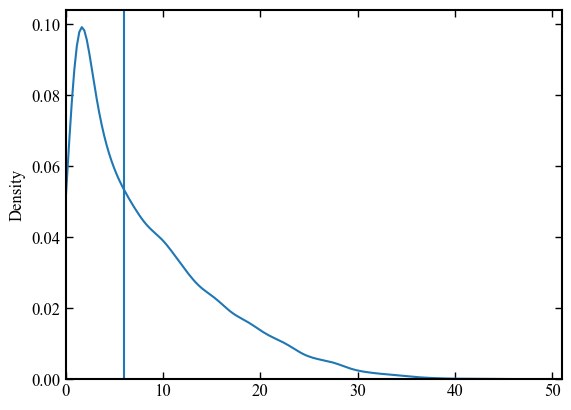

In [18]:
sns.kdeplot(N)
plt.axvline(np.median(N))
print(np.std(N))
plt.xlim(0)

In [19]:
np.unique(N, return_counts=True)[1]/10000

array([1.775e-01, 8.960e-02, 7.760e-02, 6.530e-02, 5.790e-02, 5.230e-02,
       4.970e-02, 4.280e-02, 4.040e-02, 4.220e-02, 3.400e-02, 3.290e-02,
       2.770e-02, 2.410e-02, 2.470e-02, 2.190e-02, 1.740e-02, 1.720e-02,
       1.680e-02, 1.280e-02, 1.220e-02, 1.060e-02, 1.060e-02, 6.400e-03,
       6.500e-03, 5.100e-03, 5.400e-03, 4.700e-03, 2.700e-03, 2.200e-03,
       2.100e-03, 1.300e-03, 1.600e-03, 1.000e-03, 8.000e-04, 6.000e-04,
       3.000e-04, 3.000e-04, 2.000e-04, 2.000e-04, 2.000e-04, 1.000e-04,
       1.000e-04])

In [20]:
N_test = []
M_test = []
for i in test.Nsig_acc_stellarmass:
    N_test.append(len(i))
    M_test.append(i[0])
    # except IndexError:
    #     M.append(i)

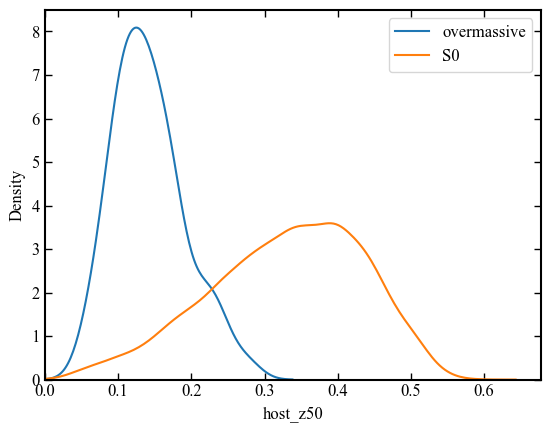

In [21]:
sns.kdeplot(np.log10(1+test.host_z50), label="overmassive")
sns.kdeplot(np.log10(1+S0.host_z50), label="S0")
plt.xlim(0)
plt.legend()
plt.show()

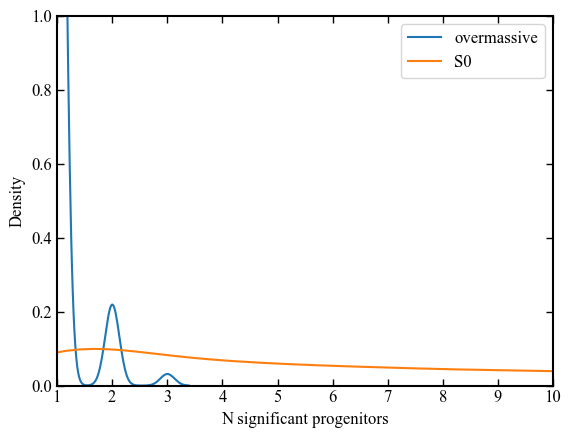

In [22]:
sns.kdeplot(N_test, label="overmassive")
sns.kdeplot(N, label="S0")
plt.xlim(1,10)
plt.ylim(0,1)
plt.xlabel("N significant progenitors")
plt.legend()
plt.show()

Text(0.5, 0, 'MMP [M$_{\\odot}$]')

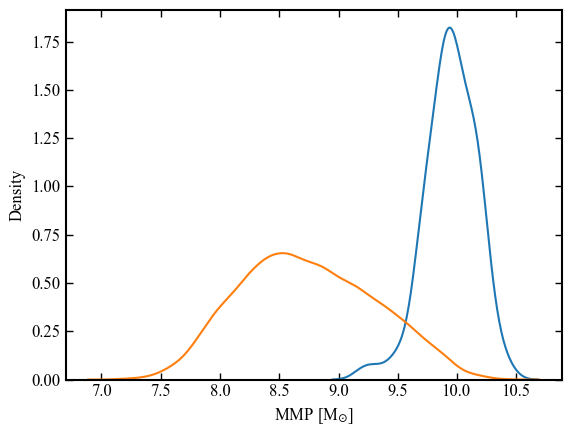

In [23]:
sns.kdeplot(np.log10(M_test), label="overmassive")
sns.kdeplot(np.log10(M), label="S0")
plt.xlabel("MMP [M$_{\\odot}$]")